<h1 style="text-align: center; color: green;" markdown="1">Prediction of Readmission for Diabetics </h1>
<h2 style="text-align: center; color: 5d7481" markdown="1">"ML Models: Random Forest, Logistic Regression, and SVM"</h2>
<h3 style="text-align: center; color: 5d7481" markdown="1">Authors: Dawit Dean, Marcus Cheema, Raymond Ye, and Brett Anwar </h2>

### Table of Contents
* [Dataset Information and Source](#anchor1)
* [Attribute Information](#anchor2)
* [Data Preprocessing](#anchor3)
* [Exploratory Data Analysis](#anchor4)
* [Training Models and Tuning](#anchor5)
* [Final Models](#anchor6)

## I. Dataset Information and Source <a id = anchor1 ></a>

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1) It is an inpatient encounter (a hospital admission).
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3) The length of stay was at least 1 day and at most 14 days.
(4) Laboratory tests were performed during the encounter.
(5) Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

## II. Atrribute Information <a id = anchor2 ></a>

## III. Data Preprocessing <a id = anchor3 ></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data
df = pd.read_csv(r'C:\Users\cheem\Documents\CS 334\diabetic_data.csv', encoding= 'unicode_escape')
pd.set_option('display.max_columns', None)


In [3]:
# removing features with many missing values: weight, payer_code, medical_specialty, encounter_id, patient_nbr
df = df.drop(['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], axis=1)

# remove rows with missing values (not that much data gets removed!)
cols = df.columns
for col in cols: 
    df = df.drop(df[df[col] == "?"].index)


# remove rows with unknown gender + convert to binary
df = df[df['gender'] != 'Unknown/Invalid']
df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})
df = df.rename(columns={'gender': 'isFemale'})

# No = 0 and [“Down,” “Steady” or “Up”] = 1 for the drugs 
def drug_transform(x):
    if x == 'No':
        return 0
    else:
        return 1

for col in df.iloc[:, 19:42]:
    df[col] = df[col].apply(drug_transform)

df = df.drop(['examide', 'citoglipton', 'metformin-rosiglitazone'], axis = 1) # drop since these drugs are rarely present

# race variable:  input missing values, one hot encoding 
df.loc[df['race'] == '?', 'race'] = 'Caucasian' # fill misisng value with most common race 
one_hot = pd.get_dummies(df['race'], prefix='race')
df = pd.concat([df, one_hot], axis=1)
df = df.drop('race', axis = 1)

# clasify into normal and abnormal boolean values
def norm(x):
    if (x == 'None') or (x == "Norm"):
        return 0
    else:
        return 1

for col in df.iloc[:, 16:18]:
    df[col] = df[col].apply(norm)  

# update change and diabetesMed values to booleans
df['change'] = df['change'].replace({'Ch': 1, 'No': 0})
df['diabetesMed'] = df['diabetesMed'].replace({'Yes': 1, 'No': 0})
df.head()

# remove unmapped data
df = df.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis = 1)


# update readmitted column 
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 0, '<30': 1})

# convert age to numerical variable
df['age'] = df['age'].str.extract('(\d+)').astype(int)
df.head()


,isFemale,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
1,1,10,3,59,0,18,0,0,0,276,250.01,255,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
2,1,20,2,11,5,13,2,0,1,648,250,V27,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0,30,2,44,1,16,0,0,0,8,250.43,403,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
4,0,40,1,51,0,8,0,0,0,197,157,250,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
5,0,50,3,31,6,16,0,0,0,414,411,250,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0


In [4]:
# mapping codes to words for diag_1, diag_2, and diag_3
mapping_dict = {
  "circulatory": range(390, 460),
  "digestive": range(520, 580),
  "genitourinary": range(580, 630),
  "diabetes": range(250,251),
  "injury": range(800, 1000),
  "musculoskeletal": range(710, 740),
  "neoplasms": range(140, 240),
  "respiratory": range(460, 520),
}

for col in ["diag_1", "diag_2", "diag_3"]:
    df[col] = df[col].astype(str)
    df[col + "_cat"] = "other"
    for cat, codes in mapping_dict.items():
        mask = df[col].str.startswith(tuple(str(code) for code in codes))
        df.loc[mask, col + "_cat"] = cat

df = df.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)   

def diag(x):
    if x == 'diabetes':
        return 1
    else:
        return 0

df['diag_1_cat'] = df['diag_1_cat'].apply(diag)   
df['diag_2_cat'] = df['diag_2_cat'].apply(diag)  
df['diag_3_cat'] = df['diag_3_cat'].apply(diag)      


df.head()
df.dtypes

isFemale                    int64
age                         int32
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
pioglitazone                int64
rosiglitazone               int64
acarbose                    int64
miglitol                    int64
troglitazone                int64
tolazamide                  int64
insulin                     int64
glyburide-metformin         int64
glipizide-metf

#### PCA: find optimal number of components

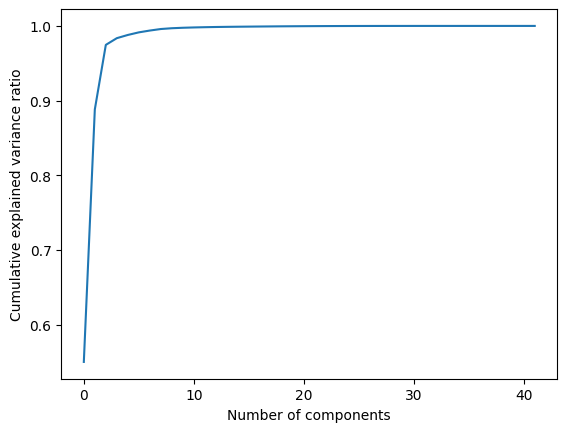

isFemale
age
time_in_hospital
num_lab_procedures
num_procedures


In [5]:
from sklearn.decomposition import PCA

X = df.drop(['readmitted'], axis = 1)


# Create a PCA object with n_components=None to extract all possible components
pca = PCA(n_components=None)

# Fit the PCA object to the data
pca.fit(X)

# Calculate the explained variance ratio (EVR) for each component
evr = pca.explained_variance_ratio_

# Calculate the cumulative sum of the EVR
cumulative_evr = np.cumsum(evr)

# Plot the cumulative EVR to determine the optimal number of components
plt.plot(cumulative_evr)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

# optimal is around n_components = 5 

top_5_features = np.argsort(evr)[::-1][:5]
feature_names = df.columns
# print the top 5 features
for i in range(5):
    print(feature_names[top_5_features[i]])

## IV. Exploratory Data Analysis <a id = anchor4 ></a>

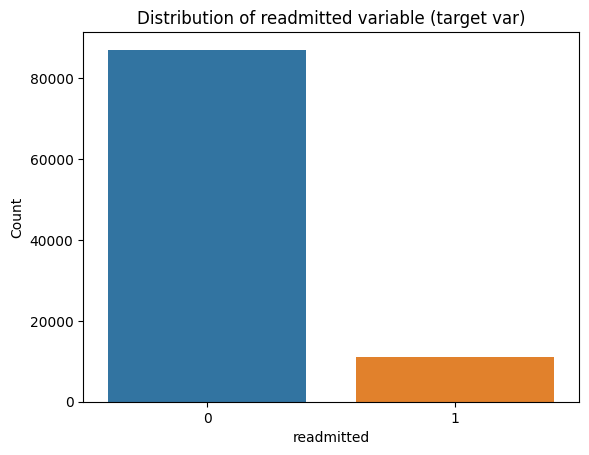

In [6]:
# create plot to show imbalance in the dataset for target variable
sns.countplot(x='readmitted', data=df)
plt.xlabel('readmitted')
plt.ylabel('Count')
plt.title('Distribution of readmitted variable (target var)')
plt.show()


## V. Model Selection and Training <a id = anchor5 ></a>

### Model 1: Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
X = df.drop('readmitted', axis = 1)
y = df.drop([col for col in df.columns if col != 'readmitted'], axis = 1).to_numpy()
y = y.ravel()


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test)

# Evaluate the performance of the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8902977971172151
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     26196
           1       0.44      0.01      0.02      3220

    accuracy                           0.89     29416
   macro avg       0.67      0.50      0.48     29416
weighted avg       0.84      0.89      0.84     29416



In [26]:
# create synthetic data using SMOTE
from imblearn.over_sampling import SMOTENC

# change the datatyope of cat variables  
X['isFemale'] = X['isFemale'].astype("category")
for col in X.iloc[:, 10:]: 
    X[col] = X[col].astype("category")

# find which vars are cats variable
cat_feat = []
for i in range(0, len(X.columns)):
    if (X.iloc[:, i].dtype == 'category'):
        cat_feat.append(i)

smote_nc = SMOTENC(categorical_features=cat_feat, sampling_strategy='minority')
X_sm, y_sm = smote_nc.fit_resample(X, y)


unique, counts = np.unique(y_sm, return_counts=True)
tab = pd.DataFrame({'value': unique, 'count': counts})
print(tab)

X_sm.head(-5) # example of 5 synthetic data observations w/ label of 1

   value  count
0      0  86986
1      1  86986


,isFemale,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,diag_1_cat,diag_2_cat,diag_3_cat
0,1,10,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0
1,1,20,2,11,5,13,2,0,1,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
2,0,30,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0
3,0,40,1,51,0,8,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1
4,0,50,3,31,6,16,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173962,1,80,5,54,2,27,0,0,1,9,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0
173963,1,80,4,53,0,26,0,0,0,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0
173964,0,80,2,31,0,13,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
173965,0,60,3,6,4,26,3,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

# Create the random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test)

# Evaluate the performance of the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8791960453709381
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     26096
           1       0.89      0.87      0.88     26096

    accuracy                           0.88     52192
   macro avg       0.88      0.88      0.88     52192
weighted avg       0.88      0.88      0.88     52192



In [10]:
from sklearn.model_selection import GridSearchCV

# find optimal hyperparameters 

# space for the Grid Search
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10, None],
    'min_samples_leaf': [1, 2, 4, None], 
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


### Model 2: Logistic Regression 

In [11]:
# create synthetic data using SMOTENC
from imblearn.over_sampling import SMOTENC

# change the datatyope of cat variables  
X['isFemale'] = X['isFemale'].astype("category")
for col in X.iloc[:, 10:]: 
    X[col] = X[col].astype("category")

# find which vars are cats variable
cat_feat = []
for i in range(0, len(X.columns)):
    if (X.iloc[:, i].dtype == 'category'):
        cat_feat.append(i)

smote_nc = SMOTENC(categorical_features=cat_feat, sampling_strategy='minority')
X_sm, y_sm = smote_nc.fit_resample(X, y)

In [12]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

print("Test-Accuracy:", accuracy_score(y_test, y_pred))
print("Train-Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_test, y_pred)) 

Test-Accuracy: 0.7482564377682404
Train-Accuracy: 0.7465429462966005
              precision    recall  f1-score   support

           0       0.75      0.74      0.75     26096
           1       0.74      0.76      0.75     26096

    accuracy                           0.75     52192
   macro avg       0.75      0.75      0.75     52192
weighted avg       0.75      0.75      0.75     52192



c:\Users\cheem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# find optimal hyperparameters
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()

# Space for grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'], 
              'max_iter': [1000]
              }

grid_search = GridSearchCV(logreg, param_grid=param_grid, cv=5)
grid_search.fit(X, y)
print(grid_search.best_params_)

### Model 3: CatBoost

In [19]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

clf = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='Logloss')

# Fit the classifier to the training data
clf.fit(X_train, y_train, cat_features = cat_feat)

# Make predictions on the test data
y_pred = clf.predict(X_test)

print("Test-Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) 

0:	learn: 0.6816752	total: 26.9ms	remaining: 26.9s
1:	learn: 0.6712746	total: 50.8ms	remaining: 25.4s
2:	learn: 0.6620687	total: 77ms	remaining: 25.6s
3:	learn: 0.6541372	total: 100ms	remaining: 25s
4:	learn: 0.6461926	total: 124ms	remaining: 24.6s
5:	learn: 0.6389556	total: 146ms	remaining: 24.2s
6:	learn: 0.6319756	total: 167ms	remaining: 23.7s
7:	learn: 0.6260668	total: 188ms	remaining: 23.3s
8:	learn: 0.6203667	total: 208ms	remaining: 22.9s
9:	learn: 0.6149929	total: 226ms	remaining: 22.4s
10:	learn: 0.6100901	total: 244ms	remaining: 21.9s
11:	learn: 0.6052251	total: 263ms	remaining: 21.7s
12:	learn: 0.6004780	total: 284ms	remaining: 21.5s
13:	learn: 0.5963191	total: 304ms	remaining: 21.4s
14:	learn: 0.5926580	total: 322ms	remaining: 21.1s
15:	learn: 0.5891372	total: 342ms	remaining: 21.1s
16:	learn: 0.5854508	total: 362ms	remaining: 20.9s
17:	learn: 0.5820489	total: 381ms	remaining: 20.8s
18:	learn: 0.5788255	total: 398ms	remaining: 20.6s
19:	learn: 0.5757087	total: 416ms	remainin

In [15]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

# find optimal parameters
# Make the grid
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [3, 6, 9],
              'iterations': [500, 1000, 1500]}

clf = CatBoostClassifier(loss_function='Logloss', cat_features=cat_feat)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1) # 5 fold cross-validation
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

## VI. Final Models <a id = anchor6 ></a>

### Model 1: Optimized Random Forest

Accuracy: 0.8819934089515634
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     26096
           1       0.89      0.87      0.88     26096

    accuracy                           0.88     52192
   macro avg       0.88      0.88      0.88     52192
weighted avg       0.88      0.88      0.88     52192



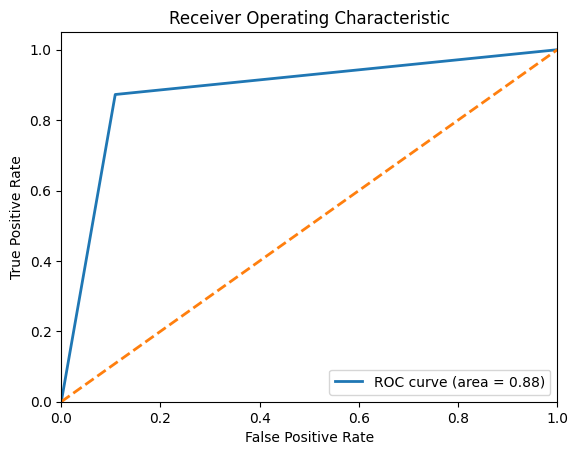

In [24]:
# These parameters were returned by the GridSearch
# Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

# Now, we'll run Random Forest using these params

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)
rfc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = None, max_features = 'sqrt', min_samples_leaf=1, min_samples_split=2)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 2: Optimized Logistic Regression

c:\Users\cheem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test-Accuracy: 0.7730495095033721
Train-Accuracy: 0.770890129742158
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     26096
           1       0.77      0.77      0.77     26096

    accuracy                           0.77     52192
   macro avg       0.77      0.77      0.77     52192
weighted avg       0.77      0.77      0.77     52192



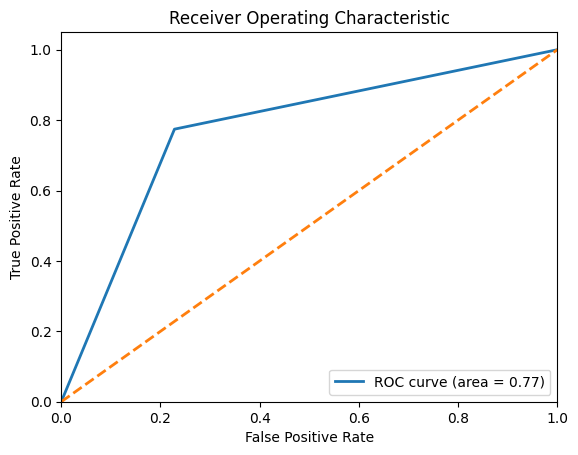

In [23]:
# These parameters were returned by the GridSearch
# Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}

# Run Logistic Regression using these Parameters

from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)

logreg = LogisticRegression(C = 1, max_iter=1000, penalty = 'l2')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

print("Test-Accuracy:", accuracy_score(y_test, y_pred))
print("Train-Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_test, y_pred)) 


# ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 3: Optimized CatBoost

0:	learn: 0.6631371	total: 35.4ms	remaining: 53s
1:	learn: 0.6386949	total: 69.4ms	remaining: 52s
2:	learn: 0.6183609	total: 103ms	remaining: 51.3s
3:	learn: 0.6011999	total: 135ms	remaining: 50.4s
4:	learn: 0.5880724	total: 164ms	remaining: 49.1s
5:	learn: 0.5764568	total: 194ms	remaining: 48.2s
6:	learn: 0.5649082	total: 223ms	remaining: 47.6s
7:	learn: 0.5567660	total: 251ms	remaining: 46.8s
8:	learn: 0.5491887	total: 282ms	remaining: 46.6s
9:	learn: 0.5435728	total: 310ms	remaining: 46.2s
10:	learn: 0.5378136	total: 338ms	remaining: 45.8s
11:	learn: 0.5333598	total: 366ms	remaining: 45.3s
12:	learn: 0.5278181	total: 395ms	remaining: 45.1s
13:	learn: 0.5237111	total: 424ms	remaining: 45s
14:	learn: 0.5182159	total: 456ms	remaining: 45.2s
15:	learn: 0.5153473	total: 487ms	remaining: 45.1s
16:	learn: 0.5088377	total: 518ms	remaining: 45.1s
17:	learn: 0.5060138	total: 552ms	remaining: 45.5s
18:	learn: 0.5022955	total: 585ms	remaining: 45.6s
19:	learn: 0.4998496	total: 618ms	remaining: 

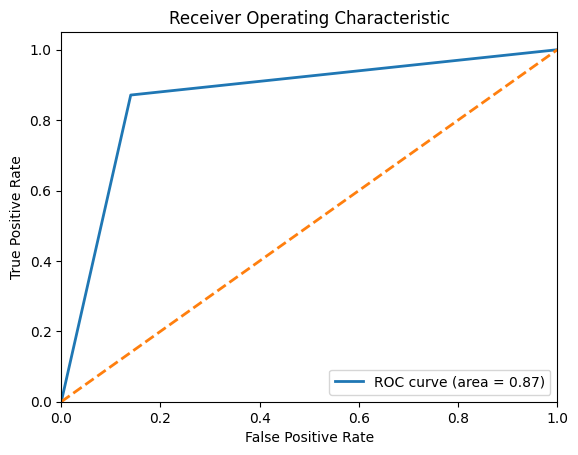

In [25]:
# These parameters were returned by the GridSearch
# Best parameters:  {'depth': 9, 'iterations': 1500, 'learning_rate': 0.1}

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

df['isFemale'] = df['isFemale'].astype("category")
for col in df.iloc[:, 10:]: 
    df[col] = df[col].astype("category")

# store cat variables
cat_feat = []
for i in range(0, len(X.columns)):
    if df.iloc[:, i].dtype == 'category':
        cat_feat.append(i)

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)

clf = CatBoostClassifier(iterations=1500, learning_rate=0.1, depth=9, loss_function='Logloss')

# Fit the classifier to the training data
clf.fit(X_train, y_train, cat_features = cat_feat)

# Make predictions on the test data
y_pred = clf.predict(X_test)

print("Test-Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) 

# ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()